In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

In [10]:
# Load Dataset
df = pd.read_csv('zomato1.csv', encoding='latin1')
print(df.head())

# Select Pre-launch Features
df = df[['online_order','book_table','location','rest_type',
         'cuisines','approx_cost(for two people)',
         'listed_in(type)','listed_in(city)','rate']]

                                                 url  \
0  https://www.zomato.com/bangalore/jalsa-banasha...   
1  https://www.zomato.com/bangalore/spice-elephan...   
2  https://www.zomato.com/SanchurroBangalore?cont...   
3  https://www.zomato.com/bangalore/addhuri-udupi...   
4  https://www.zomato.com/bangalore/grand-village...   

                                             address                   name  \
0  942, 21st Main Road, 2nd Stage, Banashankari, ...                  Jalsa   
1  2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...         Spice Elephant   
2  1112, Next to KIMS Medical College, 17th Cross...        San Churro Cafe   
3  1st Floor, Annakuteera, 3rd Stage, Banashankar...  Addhuri Udupi Bhojana   
4  10, 3rd Floor, Lakshmi Associates, Gandhi Baza...          Grand Village   

  online_order book_table   rate  votes                             phone  \
0          Yes        Yes  4.1/5    775    080 42297555\r\n+91 9743772233   
1          Yes         No  4.1/5  

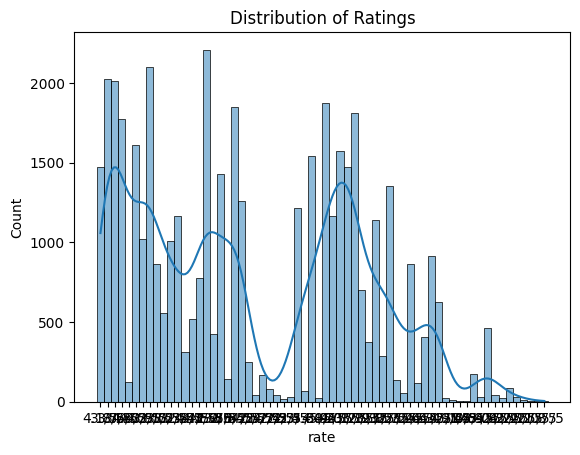

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# Rating distribution
sns.histplot(df['rate'], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.show()

In [12]:
def clean_rate(x):
    try:
        if pd.isna(x): return np.nan
        s = str(x).strip()
        if s.upper() in ['NEW','-']: return np.nan
        if '/5' in s: s = s.split('/')[0]
        return float(s)
    except:
        return np.nan

df['rate'] = df['rate'].apply(clean_rate)

In [13]:
df = df[~df['rate'].isna()]

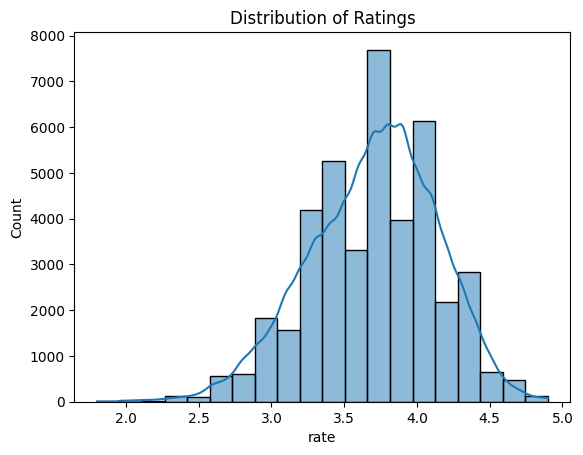

In [14]:
# Rating distribution
sns.histplot(df['rate'], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.show()

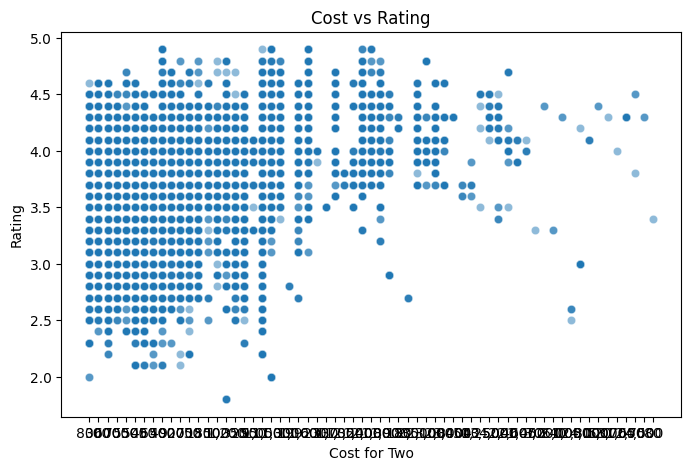

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='approx_cost(for two people)', y='rate', data=df, alpha=0.5)
plt.title("Cost vs Rating")
plt.xlabel("Cost for Two")
plt.ylabel("Rating")
plt.show()

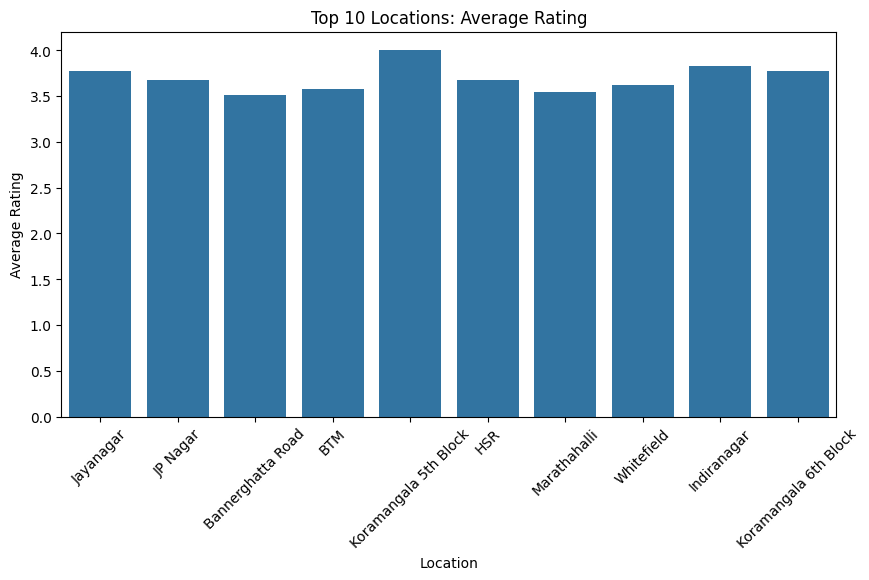

In [17]:
top_locations = df['location'].value_counts().nlargest(10).index
location_df = df[df['location'].isin(top_locations)]

plt.figure(figsize=(10,5))
sns.barplot(x='location', y='rate', data=location_df, errorbar=None)
plt.xticks(rotation=45)
plt.title("Top 10 Locations: Average Rating")
plt.xlabel("Location")
plt.ylabel("Average Rating")
plt.show()

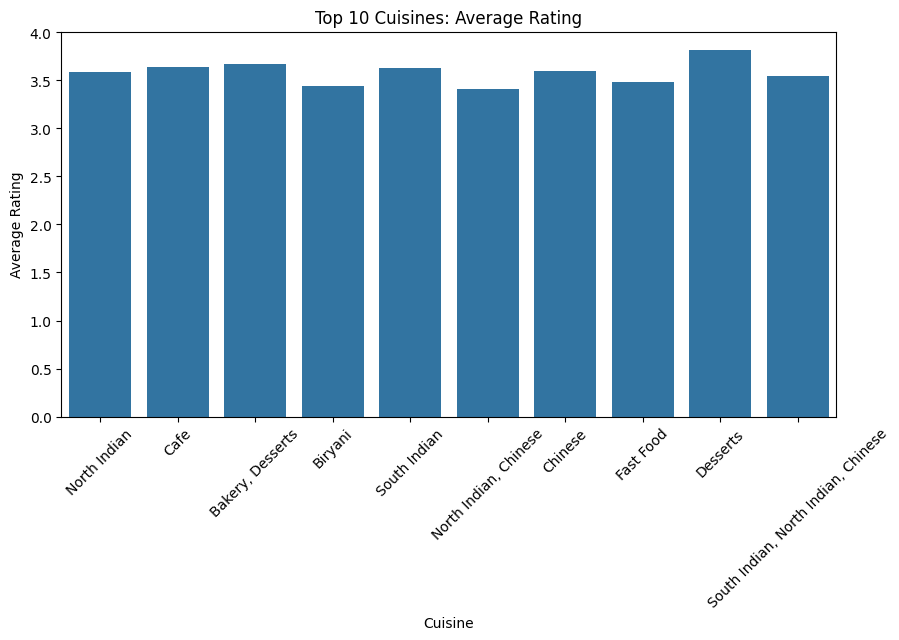

In [18]:
top_cuisines = df['cuisines'].value_counts().nlargest(10).index
cuisine_df = df[df['cuisines'].isin(top_cuisines)]

plt.figure(figsize=(10,5))
sns.barplot(x='cuisines', y='rate', data=cuisine_df, errorbar=None)
plt.xticks(rotation=45)
plt.title("Top 10 Cuisines: Average Rating")
plt.xlabel("Cuisine")
plt.ylabel("Average Rating")
plt.show()

In [19]:
df['cost_for_two'] = df['approx_cost(for two people)'].replace(',','',regex=True)
df['cost_for_two'] = pd.to_numeric(df['cost_for_two'], errors='coerce')
df['cost_for_two'] = df['cost_for_two'].fillna(df['cost_for_two'].median())  # Fill NaN with median
df = df.drop(columns=['approx_cost(for two people)'])
print(df.columns.tolist())

['online_order', 'book_table', 'location', 'rest_type', 'cuisines', 'listed_in(type)', 'listed_in(city)', 'rate', 'cost_for_two']


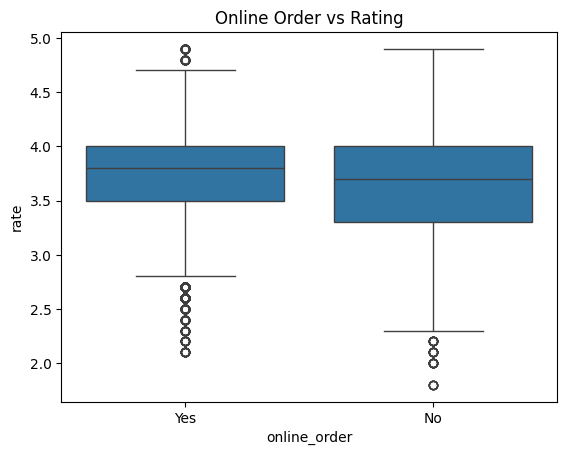

In [20]:
sns.boxplot(x='online_order', y='rate', data=df)
plt.title("Online Order vs Rating")
plt.show()

In [21]:
df['online_order'] = df['online_order'].map({'Yes':1,'No':0}).fillna(0).astype(int)
df['book_table'] = df['book_table'].map({'Yes':1,'No':0}).fillna(0).astype(int)

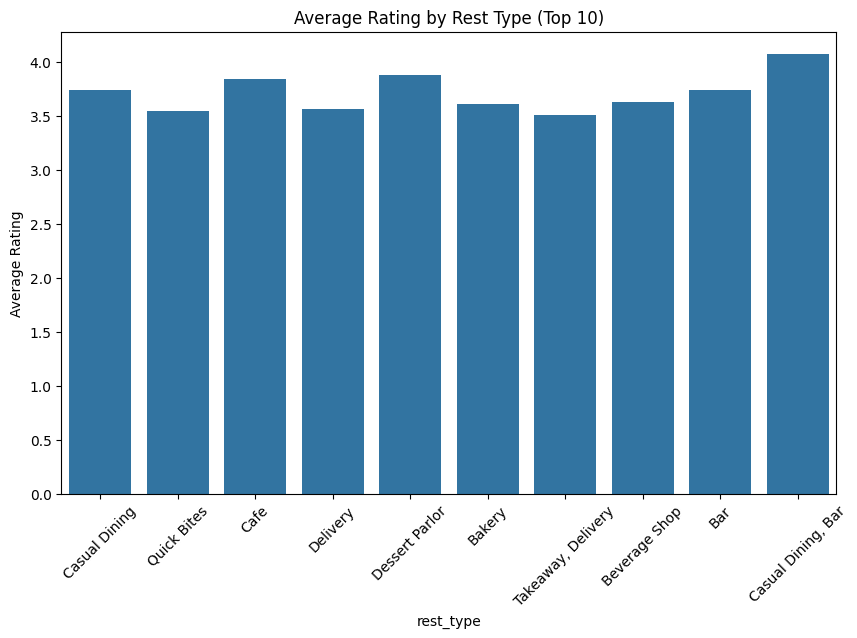

In [22]:
top_rest = df['rest_type'].value_counts().nlargest(10).index

plt.figure(figsize=(10,6))
sns.barplot(
    x='rest_type',
    y='rate',
    data=df[df['rest_type'].isin(top_rest)],
    estimator=lambda x: round(x.mean(), 2),  # average rating
    errorbar=None
)
plt.xticks(rotation=45)
plt.ylabel("Average Rating")
plt.title("Average Rating by Rest Type (Top 10)")
plt.show()

In [23]:
categorical = ['location','rest_type','listed_in(type)','listed_in(city)']
for col in categorical:
    df[col] = df[col].fillna('Unknown')

df = pd.get_dummies(df, columns=categorical, drop_first=True)

In [24]:
df['primary_cuisine'] = df['cuisines'].apply(
    lambda x: x.split(',')[0].strip() if pd.notnull(x) else 'Unknown'
)
df = pd.get_dummies(df, columns=['primary_cuisine'], drop_first=True)
df = df.drop(columns=['cuisines'], errors='ignore')

print("Data preprocessing completed. Shape after encoding:", df.shape)
print(f"Missing values per column:\n{df.isnull().sum()}")

Data preprocessing completed. Shape after encoding: (41665, 303)
Missing values per column:
online_order                  0
book_table                    0
rate                          0
cost_for_two                  0
location_Banashankari         0
                             ..
primary_cuisine_Thai          0
primary_cuisine_Tibetan       0
primary_cuisine_Turkish       0
primary_cuisine_Unknown       0
primary_cuisine_Vietnamese    0
Length: 303, dtype: int64


In [13]:
print(df.head())

   online_order  book_table  rate  cost_for_two  location_Banashankari  \
0             1           1   4.1         800.0                   True   
1             1           0   4.1         800.0                   True   
2             1           0   3.8         800.0                   True   
3             0           0   3.7         300.0                   True   
4             0           0   3.8         600.0                  False   

   location_Banaswadi  location_Bannerghatta Road  location_Basavanagudi  \
0               False                       False                  False   
1               False                       False                  False   
2               False                       False                  False   
3               False                       False                  False   
4               False                       False                   True   

   location_Basaveshwara Nagar  location_Bellandur  ...  \
0                        False         

In [14]:
X = df.drop(columns=['rate'])
y = df['rate']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Training set size: (31248, 302)
Test set size: (10417, 302)


In [15]:
# Train RandomForest Model
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

# Evaluate Model
y_pred = rf.predict(X_test)

comparison = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
comparison = comparison.reset_index(drop=True)  
print("\nPrediction Comparison (First 10)")
print(comparison.head(10))

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nModel Performance Metrics")
print(f'R² Score: {r2:.4f}')
print(f'MAE: {mae:.4f}')
print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')


Prediction Comparison (First 10)
   Actual  Predicted
0     4.3   4.295500
1     3.3   3.336033
2     3.7   3.650000
3     4.1   3.412750
4     3.5   3.519967
5     4.0   3.988179
6     3.6   3.721717
7     4.4   4.400000
8     3.8   4.042314
9     4.2   3.879500

Model Performance Metrics
R² Score: 0.7073
MAE: 0.1452
MSE: 0.0571
RMSE: 0.2390


In [16]:
# Training set performance
y_train_pred = rf.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
print(f'\nTraining R² Score: {train_r2:.4f}')
print(f'Test R² Score: {r2:.4f}')
print(f'Overfitting Check: {"Good" if abs(train_r2 - r2) < 0.1 else "Possible overfitting"}')

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nTop 10 Important Features ")
print(feature_importance.head(10))


Training R² Score: 0.9035
Test R² Score: 0.7073
Overfitting Check: Possible overfitting

Top 10 Important Features 
                            feature  importance
1                        book_table    0.191371
2                      cost_for_two    0.158341
0                      online_order    0.021818
276    primary_cuisine_North Indian    0.021735
130        rest_type_Dessert Parlor    0.018056
234            primary_cuisine_Cafe    0.016831
46   location_Koramangala 5th Block    0.014842
10            location_Brigade Road    0.012882
117         rest_type_Casual Dining    0.012351
166           rest_type_Quick Bites    0.010850


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf,
                       cv=3, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)
print("Best RF R² Score:", grid_rf.best_score_)

Best RF Params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best RF R² Score: 0.5345620187735733


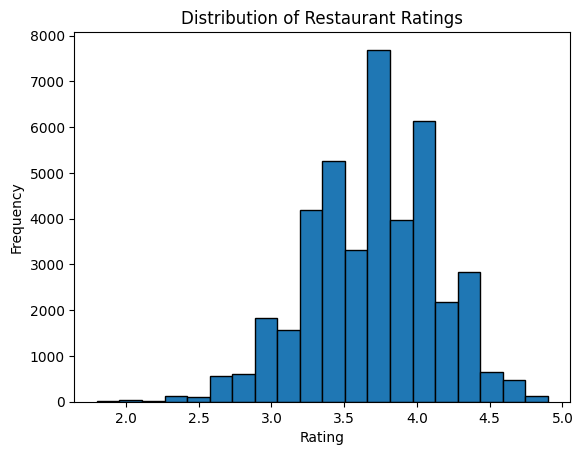

In [18]:
import matplotlib.pyplot as plt
plt.hist(df['rate'], bins=20, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Restaurant Ratings')
plt.show()

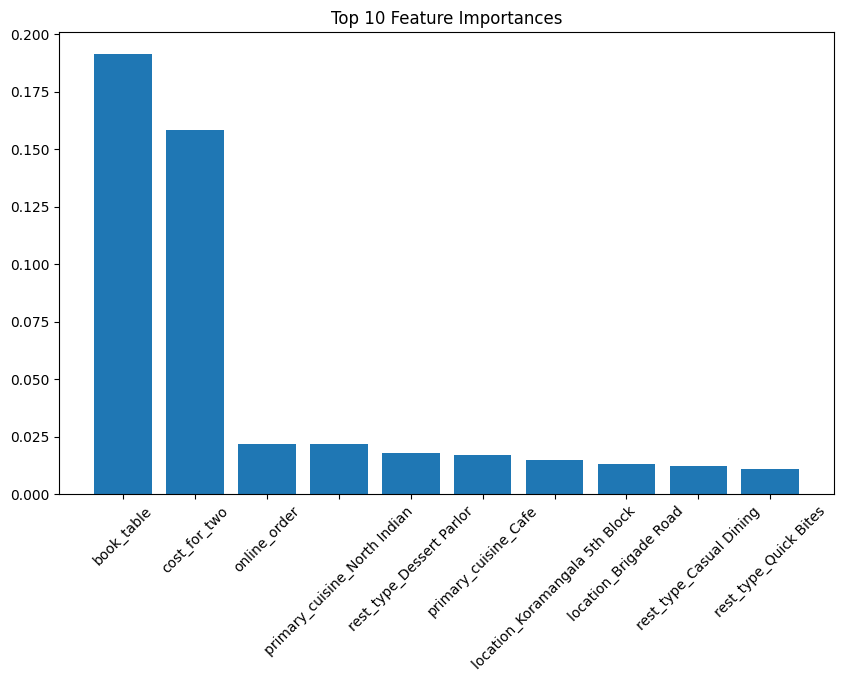

In [19]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10,6))
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), features[indices[:10]], rotation=45)
plt.title("Top 10 Feature Importances")
plt.show()

In [20]:
import xgboost as xgb
# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # compatible with all versions

print("R2 Score:", r2)
print("MAE:", mae)
print("RMSE:", rmse)

y_train_pred = xgb_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)
print(f'\nTraining R² Score: {train_r2:.4f}')
print(f'Test R² Score: {r2:.4f}')
print(f'Overfitting Check: {"Good" if abs(train_r2 - r2) < 0.1 else "Possible overfitting"}')

R2 Score: 0.6093651012654124
MAE: 0.2046609363572387
RMSE: 0.27604099421556716

Training R² Score: 0.6636
Test R² Score: 0.6094
Overfitting Check: Good


In [21]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 2]
}

grid_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42, n_jobs=-1),
                        param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best XGB Params:", grid_xgb.best_params_)
print("Best XGB R² Score:", grid_xgb.best_score_)

Best XGB Params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Best XGB R² Score: 0.5922643488060396


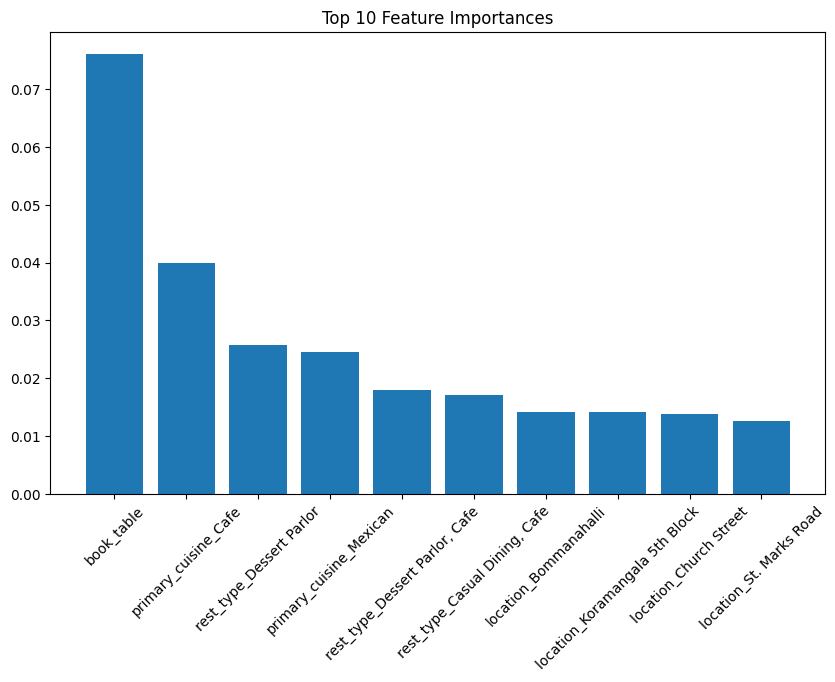

In [22]:
import matplotlib.pyplot as plt

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(10,6))
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), features[indices[:10]], rotation=45)
plt.title("Top 10 Feature Importances")
plt.show()

In [23]:
rf_pred = rf.predict(X_test)

# XGBoost predictions
xgb_pred = xgb_model.predict(X_test)

# Metrics
def print_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("R2:", r2_score(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print()

print_metrics(y_test, rf_pred, "Random Forest")
print_metrics(y_test, xgb_pred, "XGBoost")

--- Random Forest ---
R2: 0.7072722832720204
MAE: 0.1452316702901886
RMSE: 0.23895712564799781

--- XGBoost ---
R2: 0.6093651012654124
MAE: 0.2046609363572387
RMSE: 0.27604099421556716



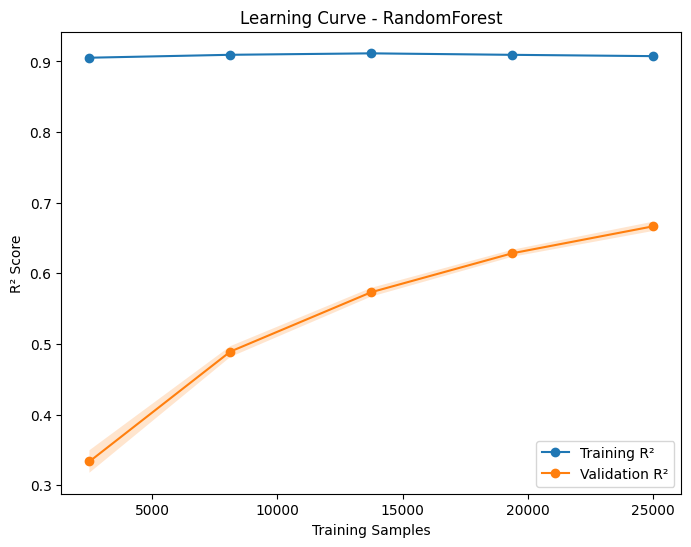

In [24]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf, X_train, y_train, cv=5, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

# Mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training R²", marker='o')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)

plt.plot(train_sizes, test_mean, label="Validation R²", marker='o')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2)

plt.xlabel("Training Samples")
plt.ylabel("R² Score")
plt.title("Learning Curve - RandomForest")
plt.legend()
plt.show()


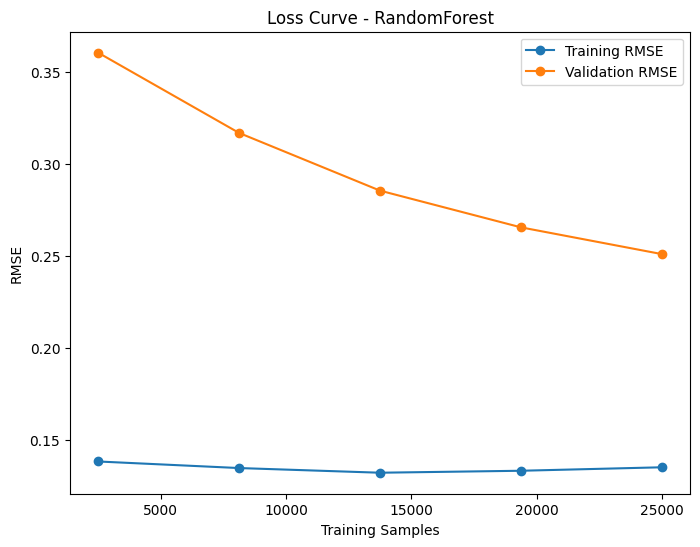

In [25]:
from sklearn.metrics import mean_squared_error

train_rmse = []
test_rmse = []

for size in train_sizes:
    # Take first "size" samples
    X_part = X_train[:int(size)]
    y_part = y_train[:int(size)]
    
    model = RandomForestRegressor(n_estimators=100,max_depth=None, random_state=42)
    model.fit(X_part, y_part)
    
    y_train_pred = model.predict(X_part)
    y_test_pred = model.predict(X_test)
    
    train_rmse.append(np.sqrt(mean_squared_error(y_part, y_train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

# Plot RMSE
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_rmse, label="Training RMSE", marker='o')
plt.plot(train_sizes, test_rmse, label="Validation RMSE", marker='o')
plt.xlabel("Training Samples")
plt.ylabel("RMSE")
plt.title("Loss Curve - RandomForest")
plt.legend()
plt.show()

In [26]:
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(comparison.head(10))  # show first 10 rows

       Actual  Predicted
22139     4.3   4.313460
37276     3.3   3.349106
15433     3.7   3.663161
44020     4.1   3.498929
23675     3.5   3.669001
36505     4.0   3.851867
46886     3.6   3.573597
39320     4.4   4.302408
42688     3.8   4.006333
39839     4.2   3.705713


In [27]:
# Example new restaurant
new_restaurant = pd.DataFrame({
    'online_order': ['Yes'],
    'book_table': ['No'],
    'location': ['Basavangudi'],
    'rest_type': ['Casual Dining,Cafe'],
    'cuisines': ['North indian,Rajasthani'],
    'approx_cost(for two people)': ['600'],
    'listed_in(type)': ['Buffet'],
    'listed_in(city)': ['Banashankari']
})

# Preprocess function
def preprocess_new(df, train_columns):
    df = df.copy()
    # Cost
    df['cost_for_two'] = df['approx_cost(for two people)'].replace(',','',regex=True).astype(float)
    df = df.drop(columns=['approx_cost(for two people)'])
    # Binary
    df['online_order'] = df['online_order'].map({'Yes':1,'No':0}).fillna(0)
    df['book_table'] = df['book_table'].map({'Yes':1,'No':0}).fillna(0)
    # Categorical
    categorical_cols = ['location','rest_type','listed_in(type)','listed_in(city)']
    for col in categorical_cols:
        df[col] = df[col].fillna('Unknown')
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    # Cuisines
    df['primary_cuisine'] = df['cuisines'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) else 'Unknown')
    df = pd.get_dummies(df, columns=['primary_cuisine'], drop_first=True)
    df = df.drop(columns=['cuisines'], errors='ignore')
    
    # Add any missing columns
    missing_cols = set(train_columns) - set(df.columns)
    for col in missing_cols:
        df[col] = 0

    # Reorder columns to match training
    df = df[train_columns]
    
    return df

# Preprocess with training columns
new_data = preprocess_new(new_restaurant, X.columns)

# Predict
predicted_rating = rf.predict(new_data)
print("Predicted Rating:", round(predicted_rating[0], 2))


Predicted Rating: 3.7


C:\Users\Anu\AppData\Local\Temp\ipykernel_6596\2280877069.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0
C:\Users\Anu\AppData\Local\Temp\ipykernel_6596\2280877069.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0
C:\Users\Anu\AppData\Local\Temp\ipykernel_6596\2280877069.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

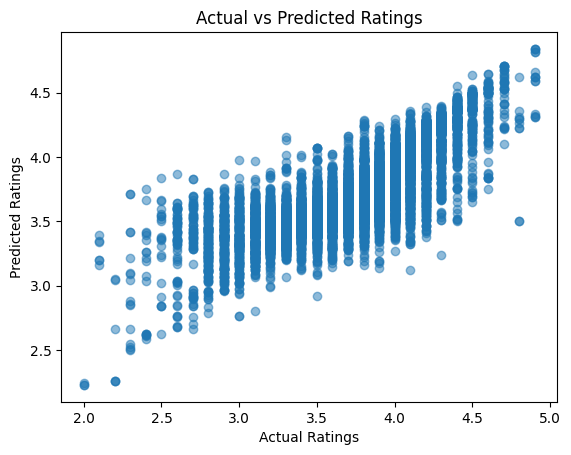

In [28]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings")
plt.show()

In [29]:
new_restaurants = pd.DataFrame({
    'online_order': ['Yes', 'No', 'Yes', 'No', 'Yes'],
    'book_table': ['No', 'Yes', 'No', 'No', 'Yes'],
    'location': ['BTM', 'Indiranagar', 'Whitefield', 'Jayanagar', 'Koramangala'],
    'rest_type': ['Casual Dining', 'Cafe', 'Quick Bites', 'Fine Dining', 'Bakery'],
    'cuisines': [
        'North Indian, Chinese',
        'Italian, Continental',
        'South Indian, Fast Food',
        'Thai, Asian',
        'Bakery, Desserts'
    ],
    'approx_cost(for two people)': ['800', '1200', '300', '1500', '500'],
    'listed_in(type)': ['Delivery', 'Dine-out', 'Delivery', 'Dine-out', 'Desserts'],
    'listed_in(city)': ['Bangalore', 'Bangalore', 'Bangalore', 'Bangalore', 'Bangalore']
})
new_data = preprocess_new(new_restaurants, X.columns)
predicted_ratings = rf.predict(new_data)

for i, rating in enumerate(predicted_ratings):
    print(f"Restaurant {i+1} Predicted Rating: {round(rating, 2)}")

Restaurant 1 Predicted Rating: 3.19
Restaurant 2 Predicted Rating: 4.24
Restaurant 3 Predicted Rating: 3.64
Restaurant 4 Predicted Rating: 4.38
Restaurant 5 Predicted Rating: 4.03


C:\Users\Anu\AppData\Local\Temp\ipykernel_6596\2280877069.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0
C:\Users\Anu\AppData\Local\Temp\ipykernel_6596\2280877069.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col] = 0
C:\Users\Anu\AppData\Local\Temp\ipykernel_6596\2280877069.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

In [30]:
import joblib
joblib.dump(rf, 'restaurant_rating_model.joblib')
joblib.dump(list(X.columns), 'X_columns.joblib')
print("Model saved as 'restaurant_rating_model.joblib'")

Model saved as 'restaurant_rating_model.joblib'


In [2]:
# Load Dataset
df = pd.read_csv('zomato1.csv', encoding='latin1')

print(df.head(2))

NameError: name 'pd' is not defined